## Loading the data

In [1]:
import pandas as pd
import numpy as np

df=pd.DataFrame(pd.read_csv('products.csv'))
df.head()


,id,title,group,salesrank,review_cnt,downloads,rating
0,1,Patterns of Preaching: A Sermon Sampler,Book,396585.0,2,2,5.0
1,2,Candlemas: Feast of Flames,Book,168596.0,12,12,4.5
2,3,World War II Allied Fighter Planes Trading Cards,Book,1270652.0,1,1,5.0
3,4,Life Application Bible Commentary: 1 and 2 Tim...,Book,631289.0,1,1,4.0
4,5,Prayers That Avail Much for Business: Executive,Book,455160.0,0,0,0.0


## filtering Amazon product data (focusing on Books).

In [2]:
df_filter=df[(df['group']=='Book')&((df['salesrank']<=150000)&(df['salesrank']>-1))]

df_cop=pd.DataFrame(pd.read_csv('copurchase.csv'))
df_cop_book=df_cop[df_cop.Source.isin(df_filter.id) & df_cop.Target.isin(df_filter.id)]
in_degree=df_cop_book.groupby(['Target'])['Source'].size().reset_index(name='in_degree')
out_degree=df_cop_book.groupby(['Source'])['Target'].size().reset_index(name='out_degree')

x = out_degree.set_index('Source')
y = in_degree.set_index('Target').rename_axis('Source')
y.columns = x.columns

combined=y.add(x, fill_value=0).loc[y.index, :].reset_index()
df_filter.head()
combined.nlargest(5,'out_degree') #Top 5 products with highest in+out degree
#2 products (33 and 4429) with highest degree.


,Source,out_degree
1,33,53.0
360,4429,53.0
23,244,36.0
32,302,22.0
471,5913,22.0


In [3]:
#grouping by source and target products to see if any particular combination has been repeated.
#We'll use this dataset to build the network graph
df_final_group=df_cop_book.groupby(['Source','Target']).size().reset_index(name='Freq')
df_final_group.head()


,Source,Target,Freq
0,12,261,1
1,74,282,1
2,77,422,1
3,79,82,1
4,117,131,1


## Build a directed co-purchase network 

In [4]:
# Load and prepare necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Create a directed graph from your co-purchase data
G = nx.from_pandas_edgelist(df_cop_book, 'Source', 'Target', create_using=nx.DiGraph())

# Add node attributes from your product data
for idx, row in df_filter.iterrows():
    if row['id'] in G.nodes():
        G.nodes[row['id']]['salesrank'] = row['salesrank']
        G.nodes[row['id']]['rating'] = row['rating'] if 'rating' in df_filter.columns else 0
        # Add other attributes you have in your dataset

# Function to create features for a product pair
def create_features(u, v, graph):
    features = {}

    # Common neighbors (number of products that both u and v are connected to)
    features['common_neighbors'] = len(list(nx.common_neighbors(graph.to_undirected(), u, v)))

    # Preferential attachment (product of degrees)
    features['pref_attachment'] = graph.out_degree(u) * graph.in_degree(v)

    # Jaccard coefficient
    u_neighbors = set(graph.successors(u))
    v_neighbors = set(graph.predecessors(v))
    if len(u_neighbors.union(v_neighbors)) > 0:
        features['jaccard'] = len(u_neighbors.intersection(v_neighbors)) / len(u_neighbors.union(v_neighbors))
    else:
        features['jaccard'] = 0

    # Resource allocation index
    features['resource_allocation'] = sum(1 / graph.degree(w) for w in nx.common_neighbors(graph.to_undirected(), u, v)) if graph.degree(u) > 0 and graph.degree(v) > 0 else 0

    # Adamic-Adar index
    features['adamic_adar'] = sum(1 / np.log(graph.degree(w)) for w in nx.common_neighbors(graph.to_undirected(), u, v) if graph.degree(w) > 1)

    # Node attributes
    if 'salesrank' in graph.nodes[u] and 'salesrank' in graph.nodes[v]:
        features['salesrank_diff'] = abs(graph.nodes[u]['salesrank'] - graph.nodes[v]['salesrank'])

    if 'rating' in graph.nodes[u] and 'rating' in graph.nodes[v]:
        features['rating_product'] = graph.nodes[u]['rating'] * graph.nodes[v]['rating']

    return features

## Construct features (e.g., common neighbors, Jaccard, salesrank difference).

In [5]:
import numpy as np
import random
import networkx as nx
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For progress tracking
import pandas as pd

# Sample a subset of edges for both positive and negative examples
def efficient_dataset_creation(G, sample_size=10000, neg_pos_ratio=1):
    """
    Create balanced dataset of positive and negative examples more efficiently

    Parameters:
    -----------
    G : networkx.Graph
        The network graph
    sample_size : int
        Maximum number of positive examples to sample
    neg_pos_ratio : float
        Ratio of negative to positive examples

    Returns:
    --------
    X : numpy array
        Feature matrix
    y : numpy array
        Labels (1 for positive, 0 for negative)
    """
    print("Creating training dataset...")

    # Sample positive examples if there are too many
    all_edges = list(G.edges())
    if len(all_edges) > sample_size:
        positive_examples = random.sample(all_edges, sample_size)
    else:
        positive_examples = all_edges

    print(f"Selected {len(positive_examples)} positive examples")

    # Pre-compute node degrees and neighbors to avoid repeated computation
    print("Pre-computing node properties...")
    degree_dict = dict(G.degree())
    in_degree_dict = dict(G.in_degree())
    out_degree_dict = dict(G.out_degree())

    # For undirected operations
    G_undir = G.to_undirected()

    # Create a dictionary of node neighbors for faster lookup
    neighbors_dict = {}
    for node in G_undir.nodes():
        neighbors_dict[node] = set(G_undir.neighbors(node))

    # Create positive examples batch
    print("Generating features for positive examples...")
    X_positive = []
    for u, v in tqdm(positive_examples):
        try:
            features = efficient_create_features(u, v, G, G_undir, degree_dict,
                                             in_degree_dict, out_degree_dict, neighbors_dict)
            X_positive.append(list(features.values()))
        except Exception as e:
            continue

    # Efficient negative sampling: Create a set of existing edges for fast lookup
    print("Creating edge lookup set...")
    edge_set = set(G.edges())

    # Generate negative examples
    print("Generating negative examples...")
    negative_examples = []
    all_nodes = list(G.nodes())
    num_nodes = len(all_nodes)

    # Calculate how many negative examples we need
    target_neg_examples = min(int(len(X_positive) * neg_pos_ratio), 100000)

    # Instead of checking randomly, sample nodes more systematically
    nodes_index = np.random.choice(num_nodes, size=min(num_nodes, 1000), replace=False)
    nodes_subset = [all_nodes[i] for i in nodes_index]

    attempts = 0
    max_attempts = target_neg_examples * 10  # Limit attempts to avoid infinite loops

    while len(negative_examples) < target_neg_examples and attempts < max_attempts:
        attempts += 1
        u = random.choice(nodes_subset)
        v = random.choice(all_nodes)

        # Use the edge set for O(1) lookup instead of O(E) graph lookup
        if u != v and (u, v) not in edge_set:
            negative_examples.append((u, v))

            # Update the subset periodically to ensure diversity
            if len(negative_examples) % 1000 == 0:
                nodes_index = np.random.choice(num_nodes, size=min(num_nodes, 1000), replace=False)
                nodes_subset = [all_nodes[i] for i in nodes_index]

    print(f"Generated {len(negative_examples)} negative examples")

    # Create negative examples batch
    print("Generating features for negative examples...")
    X_negative = []
    for u, v in tqdm(negative_examples):
        try:
            features = efficient_create_features(u, v, G, G_undir, degree_dict,
                                             in_degree_dict, out_degree_dict, neighbors_dict)
            X_negative.append(list(features.values()))
        except Exception as e:
            continue

    # Create labels
    y_positive = [1] * len(X_positive)
    y_negative = [0] * len(X_negative)

    # Combine datasets
    X = X_positive + X_negative
    y = y_positive + y_negative

    # Ensure we have features to work with
    if len(X) == 0:
        raise ValueError("No valid examples were created. Check your graph structure.")

    # Convert to arrays
    X = np.array(X)
    y = np.array(y)

    print(f"Final dataset: {X.shape[0]} examples with {X.shape[1]} features")

    return X, y

def efficient_create_features(u, v, G, G_undir, degree_dict, in_degree_dict, out_degree_dict, neighbors_dict):
    """
    Efficiently create features for a pair of nodes
    """
    features = {}

    # Get neighbor sets from pre-computed dictionary
    u_neighbors = neighbors_dict.get(u, set())
    v_neighbors = neighbors_dict.get(v, set())

    # Common neighbors
    common_neighbors = u_neighbors.intersection(v_neighbors)
    num_common = len(common_neighbors)
    features['common_neighbors'] = num_common

    # Preferential attachment (product of degrees)
    features['pref_attachment'] = out_degree_dict.get(u, 0) * in_degree_dict.get(v, 0)

    # Jaccard coefficient
    union_size = len(u_neighbors.union(v_neighbors))
    features['jaccard'] = num_common / union_size if union_size > 0 else 0

    # Adamic-Adar index
    features['adamic_adar'] = sum(1 / np.log(degree_dict.get(w, 1))
                                for w in common_neighbors
                                if degree_dict.get(w, 1) > 1)

    # Resource allocation
    features['resource_allocation'] = sum(1 / degree_dict.get(w, 1)
                                       for w in common_neighbors
                                       if degree_dict.get(w, 1) > 0)

    # Add node attributes if available
    node_attrs = G.nodes
    if u in node_attrs and v in node_attrs:
        if 'salesrank' in node_attrs[u] and 'salesrank' in node_attrs[v]:
            features['salesrank_diff'] = abs(node_attrs[u]['salesrank'] - node_attrs[v]['salesrank'])

        if 'rating' in node_attrs[u] and 'rating' in node_attrs[v]:
            features['rating_product'] = node_attrs[u]['rating'] * node_attrs[v]['rating']

    return features

# Main execution
def build_copurchase_model(G, df_filter, sample_size=10000):
    """
    Build a model to predict co-purchases with efficiency optimizations
    """
    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    # Generate dataset efficiently - adjust sample size based on your computational resources
    X, y = efficient_dataset_creation(G, sample_size=sample_size)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    print(f"Training set: {X_train.shape[0]} examples")
    print(f"Testing set: {X_test.shape[0]} examples")

    return X_train, X_test, y_train, y_test

In [6]:
# Create your graph first
G = nx.from_pandas_edgelist(df_cop_book, 'Source', 'Target', create_using=nx.DiGraph())

# Add node attributes
for idx, row in df_filter.iterrows():
    if row['id'] in G.nodes():
        G.nodes[row['id']]['salesrank'] = row['salesrank']
        if 'rating' in df_filter.columns:
            G.nodes[row['id']]['rating'] = row['rating']

# Build model with sample size based on your resources
# Start with smaller sample size like 5000 and increase if needed
X_train, X_test, y_train, y_test = build_copurchase_model(G, df_filter, sample_size=5000)

# Train a simple model first to test
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
rf_prob = rf_model.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score
print(f"ROC-AUC: {roc_auc_score(y_test, rf_prob):.4f}")

Graph has 20684 nodes and 22460 edges
Creating training dataset...
Selected 5000 positive examples
Pre-computing node properties...
Generating features for positive examples...


100%|██████████| 5000/5000 [00:00<00:00, 109451.27it/s]


Creating edge lookup set...
Generating negative examples...
Generated 5000 negative examples
Generating features for negative examples...


100%|██████████| 5000/5000 [00:00<00:00, 143639.56it/s]

Final dataset: 10000 examples with 7 features
Training set: 7000 examples
Testing set: 3000 examples


ROC-AUC: 0.7788


## Evaluate performance using metrics like ROC-AUC and Precision-Recall.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from joblib import dump, load
import networkx as nx
from tqdm import tqdm
import random

def train_multiple_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple classification models for co-purchase prediction

    Parameters:
    -----------
    X_train : numpy array
        Training features
    X_test : numpy array
        Testing features
    y_train : numpy array
        Training labels
    y_test : numpy array
        Testing labels

    Returns:
    --------
    results : list of dictionaries
        Model performance metrics for each model
    """
    # Define models to evaluate
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, random_state=42)
    }

    # Store results for each model
    results = []

    # Define feature names for interpretation
    feature_names = [
        'Common Neighbors',
        'Preferential Attachment',
        'Jaccard Coefficient',
        'Adamic-Adar Index',
        'Resource Allocation',
        'Salesrank Difference',
        'Rating Product'
    ]

    # Train and evaluate each model
    for name, model in models.items():
        print(f"\n{'-'*50}")
        print(f"Training {name}...")

        # Record start time
        start_time = time.time()

        # Train the model
        model.fit(X_train, y_train)

        # Record training time
        train_time = time.time() - start_time

        # Make predictions
        y_pred = model.predict(X_test)

        # Get probability predictions if available
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            y_prob = y_pred  # Just use binary predictions

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        cm = confusion_matrix(y_test, y_pred)

        # Print metrics
        print(f"Training time: {train_time:.2f} seconds")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC-AUC: {auc:.4f}")

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

        # Feature importance for tree-based models
        if name in ['Random Forest', 'Gradient Boosting']:
            plt.figure(figsize=(10, 6))
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]  # Sort in descending order

            plt.title(f'Feature Importance - {name}')
            plt.bar(range(len(indices)), importances[indices], align='center')
            plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
            plt.xlim([-1, len(indices)])
            plt.tight_layout()
            plt.show()

            print("\nFeature Importance:")
            for i, idx in enumerate(indices):
                print(f"{feature_names[idx]}: {importances[idx]:.4f}")

        # For logistic regression, show coefficients
        elif name == 'Logistic Regression':
            plt.figure(figsize=(10, 6))
            coefs = model.coef_[0]
            indices = np.argsort(np.abs(coefs))[::-1]  # Sort by absolute value

            plt.title(f'Feature Coefficients - {name}')
            plt.bar(range(len(indices)), coefs[indices], align='center')
            plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
            plt.xlim([-1, len(indices)])
            plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
            plt.tight_layout()
            plt.show()

            print("\nFeature Coefficients:")
            for i, idx in enumerate(indices):
                print(f"{feature_names[idx]}: {coefs[idx]:.4f}")

        # Store results
        results.append({
            'model_name': name,
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'train_time': train_time,
            'confusion_matrix': cm,
            'y_prob': y_prob
        })

    # Create a comparison dataframe
    comparison_df = pd.DataFrame([
        {
            'Model': r['model_name'],
            'Accuracy': r['accuracy'],
            'Precision': r['precision'],
            'Recall': r['recall'],
            'F1 Score': r['f1'],
            'AUC': r['auc'],
            'Training Time (s)': r['train_time']
        } for r in results
    ])

    # Sort by accuracy (or another metric of your choice)
    comparison_df = comparison_df.sort_values('AUC', ascending=False).reset_index(drop=True)

    print("\nModel Comparison:")
    print(comparison_df.to_string())

    # Plot ROC curves for all models
    plt.figure(figsize=(10, 8))
    for result in results:
        fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
        plt.plot(fpr, tpr, label=f"{result['model_name']} (AUC = {result['auc']:.4f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Co-Purchase Prediction Models')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Find the best model
    best_idx = comparison_df['AUC'].idxmax()
    best_model_name = comparison_df.loc[best_idx, 'Model']
    best_model = next(r['model'] for r in results if r['model_name'] == best_model_name)

    print(f"\nBest model: {best_model_name} (AUC: {comparison_df.loc[best_idx, 'AUC']:.4f})")

    return results, best_model_name, best_model

def hyperparameter_tuning(X_train, y_train, best_model_name):
    """
    Perform hyperparameter tuning for the best model

    Parameters:
    -----------
    X_train : numpy array
        Training features
    y_train : numpy array
        Training labels
    best_model_name : str
        Name of the best model to tune

    Returns:
    --------
    best_model : sklearn model
        Tuned model with best parameters
    """
    print(f"\n{'-'*50}")
    print(f"Tuning hyperparameters for {best_model_name}...")

    # Define parameters for different model types
    if best_model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42)
        param_dist = {
            'n_estimators': randint(50, 300),
            'max_depth': [None] + list(randint(5, 30).rvs(5)),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 'log2', None]
        }

    elif best_model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier(random_state=42)
        param_dist = {
            'n_estimators': randint(50, 300),
            'learning_rate': uniform(0.01, 0.3),
            'max_depth': randint(2, 10),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'subsample': uniform(0.6, 0.4)
        }

    elif best_model_name == 'Logistic Regression':
        model = LogisticRegression(random_state=42)
        param_dist = {
            'C': uniform(0.1, 10),
            'penalty': ['l1', 'l2', 'elasticnet', None],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
            'max_iter': randint(100, 1000)
        }

    elif best_model_name == 'Neural Network':
        model = MLPClassifier(random_state=42)
        param_dist = {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['tanh', 'relu'],
            'alpha': uniform(0.0001, 0.01),
            'learning_rate': ['constant', 'adaptive'],
            'max_iter': randint(200, 500)
        }

    elif best_model_name == 'K-Nearest Neighbors':
        model = KNeighborsClassifier()
        param_dist = {
            'n_neighbors': randint(3, 15),
            'weights': ['uniform', 'distance'],
            'p': [1, 2]  # Manhattan or Euclidean distance
        }

    else:
        print(f"Tuning not configured for {best_model_name}")
        return None

    # Run randomized search with cross-validation
    random_search = RandomizedSearchCV(
        model, param_distributions=param_dist,
        n_iter=20, cv=3, scoring='roc_auc',
        random_state=42, n_jobs=-1, verbose=1
    )

    random_search.fit(X_train, y_train)

    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best CV score: {random_search.best_score_:.4f}")

    return random_search.best_estimator_

def evaluate_tuned_model(tuned_model, X_train, X_test, y_train, y_test, best_model_name):
    """
    Evaluate the tuned model

    Parameters:
    -----------
    tuned_model : sklearn model
        The tuned model to evaluate
    X_train, X_test, y_train, y_test : numpy arrays
        Training and testing data
    best_model_name : str
        Name of the model being evaluated

    Returns:
    --------
    metrics : dict
        Model performance metrics
    """
    print(f"\n{'-'*50}")
    print(f"Evaluating tuned {best_model_name}...")

    # Record start time
    start_time = time.time()

    # Train the model
    tuned_model.fit(X_train, y_train)

    # Record training time
    train_time = time.time() - start_time

    # Make predictions
    y_pred = tuned_model.predict(X_test)
    y_prob = tuned_model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    # Print metrics
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {auc:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - Tuned {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Compare ROC curve with non-tuned model
    plt.figure(figsize=(10, 8))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"Tuned {best_model_name} (AUC = {auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Tuned {best_model_name}')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {
        'model_name': f"Tuned {best_model_name}",
        'model': tuned_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'train_time': train_time,
        'confusion_matrix': cm,
        'y_prob': y_prob
    }

def predict_future_copurchases(G, best_model, df_filter, feature_names, sample_size=5000):
    """
    Predict most likely future co-purchases

    Parameters:
    -----------
    G : networkx.DiGraph
        The co-purchase network
    best_model : sklearn model
        The trained model to use for prediction
    df_filter : pandas DataFrame
        DataFrame with product information
    feature_names : list
        Names of features used in the model
    sample_size : int
        Maximum number of potential pairs to evaluate

    Returns:
    --------
    top_predictions : pandas DataFrame
        Dataframe with most likely co-purchases
    """
    print(f"\n{'-'*50}")
    print("Predicting future co-purchases...")

    # Pre-compute node properties for efficiency
    print("Pre-computing network properties...")
    degree_dict = dict(G.degree())
    in_degree_dict = dict(G.in_degree())
    out_degree_dict = dict(G.out_degree())

    # For undirected operations
    G_undir = G.to_undirected()

    # Create a dictionary of node neighbors for faster lookup
    neighbors_dict = {}
    for node in tqdm(G_undir.nodes(), desc="Computing neighbors"):
        neighbors_dict[node] = set(G_undir.neighbors(node))

    # Create a set of existing edges for O(1) lookup
    edge_set = set(G.edges())

    # Sample nodes to limit computation
    all_nodes = list(G.nodes())
    num_nodes = len(all_nodes)

    # Select a subset of nodes for prediction to keep computation manageable
    if num_nodes > 1000:
        source_nodes = random.sample(all_nodes, 1000)
    else:
        source_nodes = all_nodes

    # Container to store potential co-purchases
    potential_copurchases = []
    processed = 0

    print("Generating potential co-purchase pairs...")
    for u in tqdm(source_nodes, desc="Processing nodes"):
        # For efficiency, focus on 2-hop neighbors (more likely to form new links)
        two_hop_neighbors = set()
        for neighbor in neighbors_dict.get(u, set()):
            two_hop_neighbors.update(neighbors_dict.get(neighbor, set()))

        # Remove existing neighbors and self
        two_hop_neighbors -= neighbors_dict.get(u, set())
        if u in two_hop_neighbors:
            two_hop_neighbors.remove(u)

        # Sample if there are too many
        candidates = list(two_hop_neighbors)
        if len(candidates) > 20:
            candidates = random.sample(candidates, 20)

        # Generate features for each potential pair
        for v in candidates:
            if (u, v) not in edge_set:  # Verify edge doesn't exist
                try:
                    # Compute features for this node pair
                    features = {}

                    # Common neighbors
                    u_neighbors = neighbors_dict.get(u, set())
                    v_neighbors = neighbors_dict.get(v, set())
                    common_neighbors = u_neighbors.intersection(v_neighbors)
                    num_common = len(common_neighbors)
                    features['common_neighbors'] = num_common

                    # Preferential attachment
                    features['pref_attachment'] = out_degree_dict.get(u, 0) * in_degree_dict.get(v, 0)

                    # Jaccard coefficient
                    union_size = len(u_neighbors.union(v_neighbors))
                    features['jaccard'] = num_common / union_size if union_size > 0 else 0

                    # Adamic-Adar index
                    features['adamic_adar'] = sum(1 / np.log(degree_dict.get(w, 1))
                                               for w in common_neighbors
                                               if degree_dict.get(w, 1) > 1)

                    # Resource allocation
                    features['resource_allocation'] = sum(1 / degree_dict.get(w, 1)
                                                      for w in common_neighbors
                                                      if degree_dict.get(w, 1) > 0)

                    # Add node attributes if available
                    node_attrs = G.nodes
                    if u in node_attrs and v in node_attrs:
                        if 'salesrank' in node_attrs[u] and 'salesrank' in node_attrs[v]:
                            features['salesrank_diff'] = abs(node_attrs[u]['salesrank'] - node_attrs[v]['salesrank'])
                        else:
                            features['salesrank_diff'] = 0

                        if 'rating' in node_attrs[u] and 'rating' in node_attrs[v]:
                            features['rating_product'] = node_attrs[u]['rating'] * node_attrs[v]['rating']
                        else:
                            features['rating_product'] = 0
                    else:
                        features['salesrank_diff'] = 0
                        features['rating_product'] = 0

                    # Add to potential co-purchases
                    potential_copurchases.append((u, v, list(features.values())))
                    processed += 1

                    # Limit the number to avoid memory issues
                    if processed >= sample_size:
                        break
                except Exception as e:
                    continue

        if processed >= sample_size:
            break

    # Convert features to array
    if not potential_copurchases:
        print("No potential co-purchases found!")
        return None

    sources = [p[0] for p in potential_copurchases]
    targets = [p[1] for p in potential_copurchases]
    potential_features = np.array([p[2] for p in potential_copurchases])

    print(f"Making predictions on {len(potential_features)} potential co-purchases...")

    # Make predictions using the best model
    potential_probs = best_model.predict_proba(potential_features)[:, 1]

    # Create a dataframe with predictions
    prediction_df = pd.DataFrame({
        'source': sources,
        'target': targets,
        'probability': potential_probs
    })

    # Sort by probability in descending order
    prediction_df = prediction_df.sort_values('probability', ascending=False)

    # Display top 20 most likely future co-purchases
    top_predictions = prediction_df.head(20)
    print("\nTop 20 most likely future co-purchases:")
    print(top_predictions)

    # Merge with product information for better interpretation
    if 'title' in df_filter.columns:
        top_predictions_with_info = top_predictions.merge(
            df_filter[['id', 'title']],
            left_on='source',
            right_on='id'
        ).drop('id', axis=1).rename(columns={'title': 'source_title'})

        top_predictions_with_info = top_predictions_with_info.merge(
            df_filter[['id', 'title']],
            left_on='target',
            right_on='id'
        ).drop('id', axis=1).rename(columns={'title': 'target_title'})

        print("\nTop predicted co-purchases with titles:")
        print(top_predictions_with_info[['source', 'source_title', 'target', 'target_title', 'probability']])

        return top_predictions_with_info
    else:
        return top_predictions

def visualize_network_with_predictions(G, top_predictions, df_filter, max_nodes=100):
    """
    Visualize the network with top predicted co-purchases

    Parameters:
    -----------
    G : networkx.DiGraph
        The co-purchase network
    top_predictions : pandas DataFrame
        DataFrame with predicted co-purchases
    df_filter : pandas DataFrame
        DataFrame with product information
    max_nodes : int
        Maximum number of nodes to include in visualization
    """
    print(f"\n{'-'*50}")
    print("Visualizing network with predictions...")

    # Get top predicted pairs
    top_sources = list(top_predictions['source'].values[:10])
    top_targets = list(top_predictions['target'].values[:10])
    top_products = set(top_sources + top_targets)

    # Build a neighborhood around these products
    neighborhood = set(top_products)
    for node in top_products:
        if node in G:
            neighborhood.update(list(G.predecessors(node))[:5])  # Limit to 5 predecessors
            neighborhood.update(list(G.successors(node))[:5])    # Limit to 5 successors

    # Limit size for visualization
    if len(neighborhood) > max_nodes:
        # Keep all top products and sample the rest
        other_nodes = list(neighborhood - top_products)
        sampled_others = random.sample(other_nodes, max_nodes - len(top_products))
        neighborhood = set(list(top_products) + sampled_others)

    # Create subgraph
    subgraph = G.subgraph(neighborhood)

    # Get predicted edges
    predicted_edges = []
    for _, row in top_predictions.head(10).iterrows():
        source, target = row['source'], row['target']
        if source in neighborhood and target in neighborhood:
            predicted_edges.append((source, target))

    # Plot the network
    plt.figure(figsize=(12, 10))

    # Use spring layout for node positions
    pos = nx.spring_layout(subgraph, seed=42)

    # Draw existing edges
    nx.draw_networkx_edges(subgraph, pos, alpha=0.3, edge_color='gray')

    # Draw predicted edges in a distinct color
    nx.draw_networkx_edges(subgraph, pos, edgelist=predicted_edges,
                          edge_color='red', width=2, alpha=0.7)

    # Draw nodes
    node_colors = ['#FF7F0E' if node in top_products else '#1F77B4' for node in subgraph.nodes()]
    node_sizes = [300 if node in top_products else 100 for node in subgraph.nodes()]
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors)

    # Add labels if there aren't too many nodes
    if len(subgraph) <= 30 and 'title' in df_filter.columns:
        labels = {}
        for node in subgraph.nodes():
            product = df_filter[df_filter['id'] == node]
            if not product.empty and 'title' in product.columns:
                title = product['title'].values[0]
                labels[node] = f"{node}: {title[:15]}..." if len(title) > 15 else f"{node}: {title}"
            else:
                labels[node] = str(node)
        nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8)
    else:
        # Just show node IDs for larger graphs
        labels = {node: str(node) for node in subgraph.nodes()}
        nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8)

    plt.title('Co-Purchase Network with Predicted New Links (in red)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Create a legend
    plt.figure(figsize=(5, 2))
    plt.plot([0], [0], 'o', color='#FF7F0E', markersize=10, label='Products in Top Predictions')
    plt.plot([0], [0], 'o', color='#1F77B4', markersize=10, label='Other Products')
    plt.plot([0], [0], '-', color='gray', alpha=0.3, label='Existing Co-Purchase')
    plt.plot([0], [0], '-', color='red', linewidth=2, alpha=0.7, label='Predicted Co-Purchase')
    plt.legend(loc='center', frameon=False, fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def main_analysis(X_train, X_test, y_train, y_test, G, df_filter):
    """
    Run the complete analysis pipeline

    Parameters:
    -----------
    X_train, X_test, y_train, y_test : numpy arrays
        Training and testing data
    G : networkx.DiGraph
        The co-purchase network
    df_filter : pandas DataFrame
        DataFrame with product information
    """
    # Define feature names for interpretation
    feature_names = [
        'Common Neighbors',
        'Preferential Attachment',
        'Jaccard Coefficient',
        'Adamic-Adar Index',
        'Resource Allocation',
        'Salesrank Difference',
        'Rating Product'
    ]

    # 1. Train multiple models
    results, best_model_name, best_model = train_multiple_models(X_train, X_test, y_train, y_test)

    # 2. Hyperparameter tuning
    tuned_model = hyperparameter_tuning(X_train, y_train, best_model_name)

    # 3. Evaluate tuned model
    if tuned_model is not None:
        tuned_result = evaluate_tuned_model(tuned_model, X_train, X_test, y_train, y_test, best_model_name)
        final_model = tuned_model
    else:
        final_model = best_model

    # 4. Predict future co-purchases
    top_predictions = predict_future_copurchases(G, final_model, df_filter, feature_names)

    # 5. Visualize network with predictions
    if top_predictions is not None:
        visualize_network_with_predictions(G, top_predictions, df_filter)

    # 6. Save the final model
    try:
        dump(final_model, 'copurchase_prediction_model.joblib')
        print("Model saved to 'copurchase_prediction_model.joblib'")
    except:
        print("Note: Could not save model to disk")

    return final_model, top_predictions

# Example usage:
# main_analysis(X_train, X_test, y_train, y_test, G, df_filter)


--------------------------------------------------
Training Random Forest...
Training time: 0.74 seconds
Accuracy: 0.6763
Precision: 0.6809
Recall: 0.6929
F1 Score: 0.6869
ROC-AUC: 0.7805


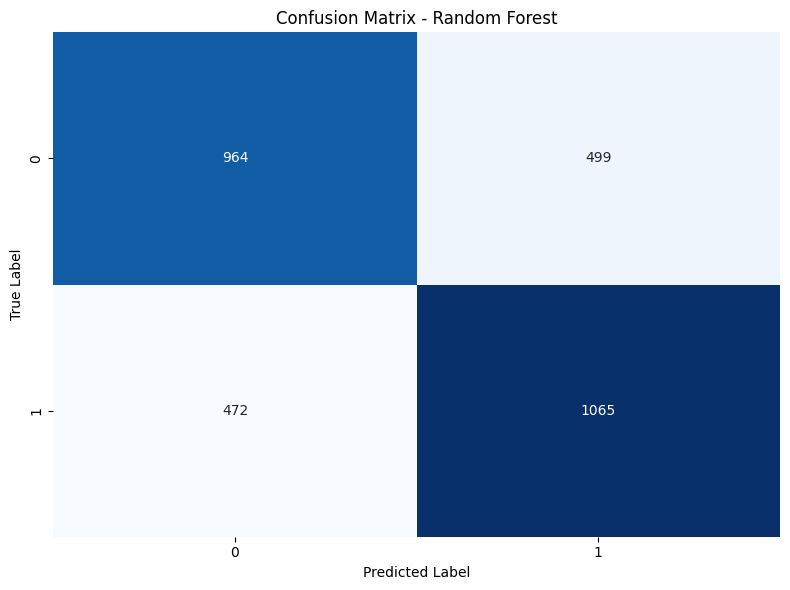

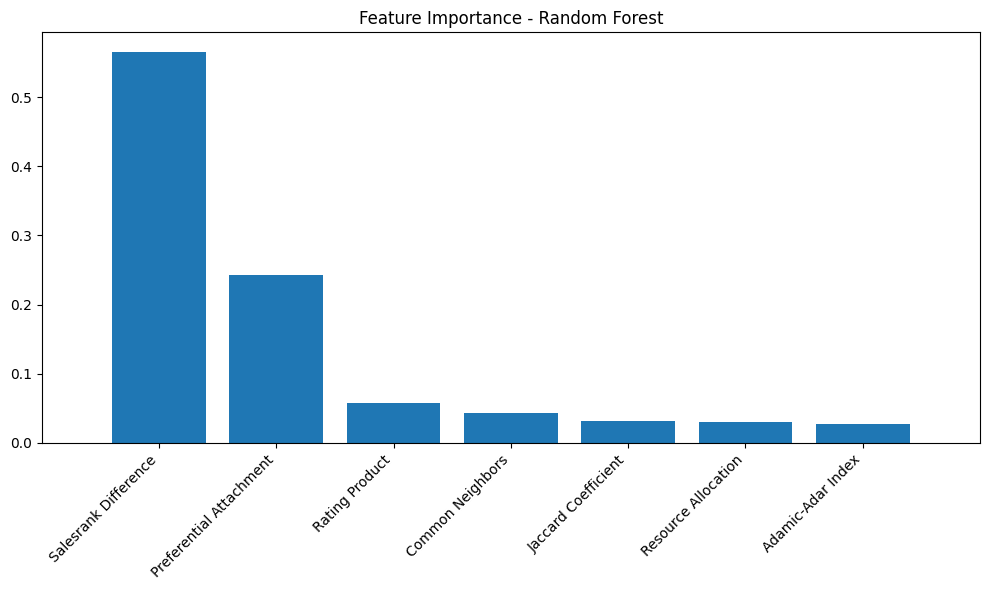


Feature Importance:
Salesrank Difference: 0.5655
Preferential Attachment: 0.2430
Rating Product: 0.0575
Common Neighbors: 0.0434
Jaccard Coefficient: 0.0324
Resource Allocation: 0.0308
Adamic-Adar Index: 0.0275

--------------------------------------------------
Training Logistic Regression...
Training time: 1.90 seconds
Accuracy: 0.6693
Precision: 0.7959
Recall: 0.4769
F1 Score: 0.5964
ROC-AUC: 0.7920


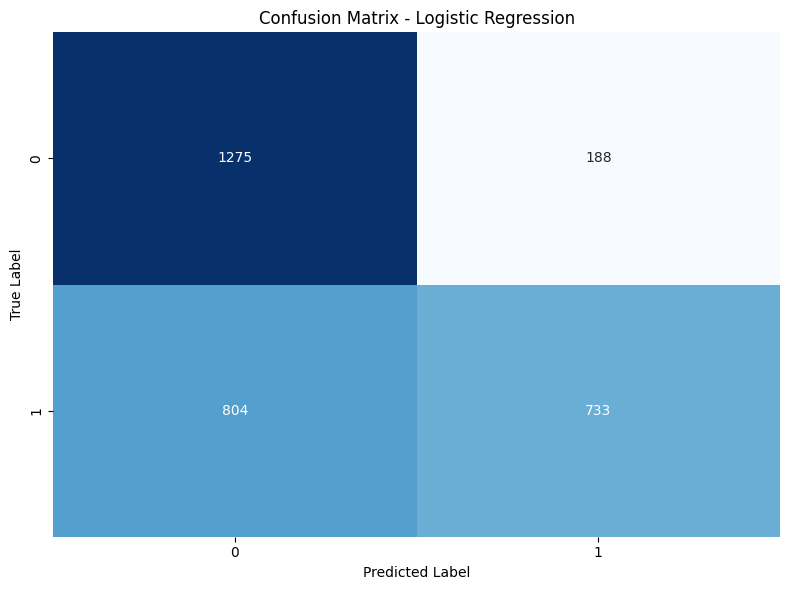

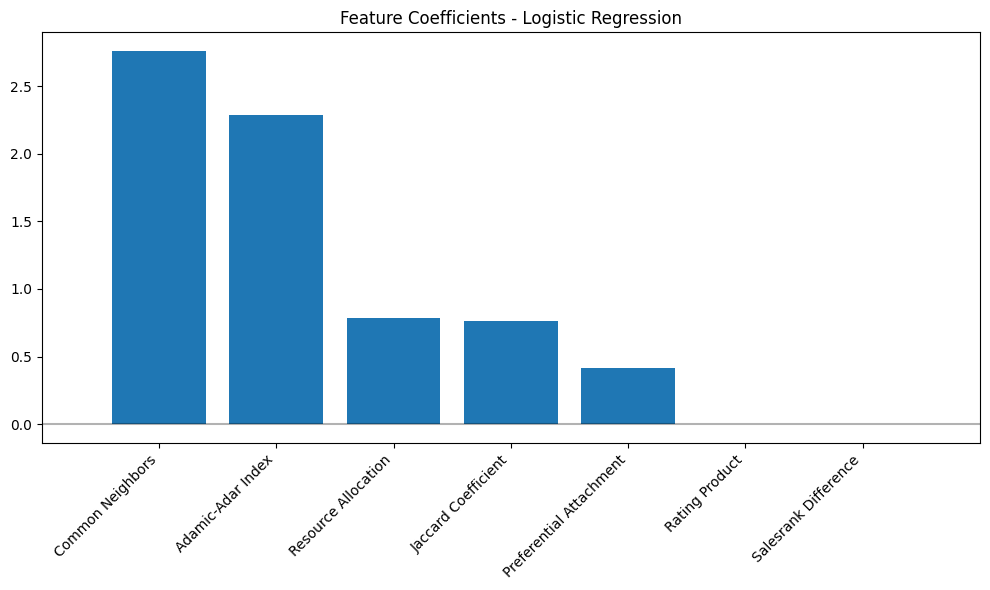


Feature Coefficients:
Common Neighbors: 2.7603
Adamic-Adar Index: 2.2905
Resource Allocation: 0.7863
Jaccard Coefficient: 0.7626
Preferential Attachment: 0.4133
Rating Product: -0.0007
Salesrank Difference: 0.0000

--------------------------------------------------
Training Gradient Boosting...
Training time: 0.72 seconds
Accuracy: 0.6827
Precision: 0.6652
Recall: 0.7664
F1 Score: 0.7122
ROC-AUC: 0.7935


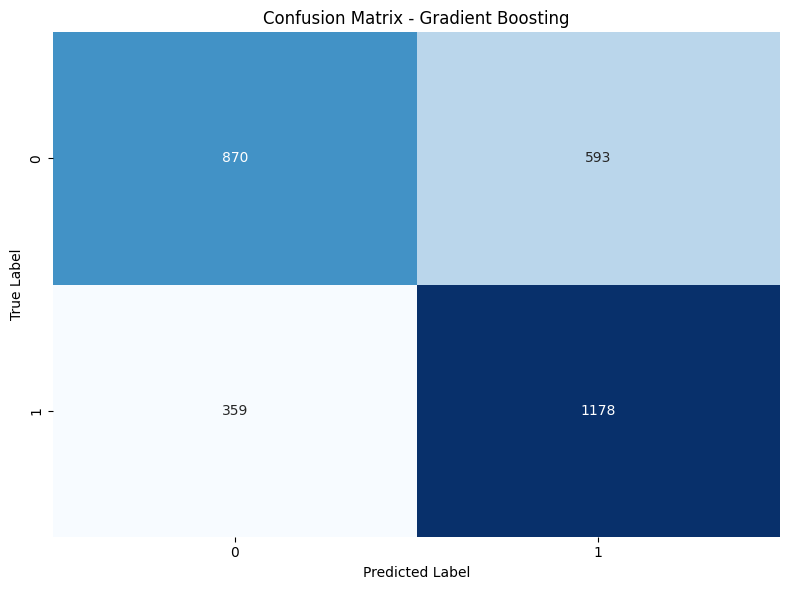

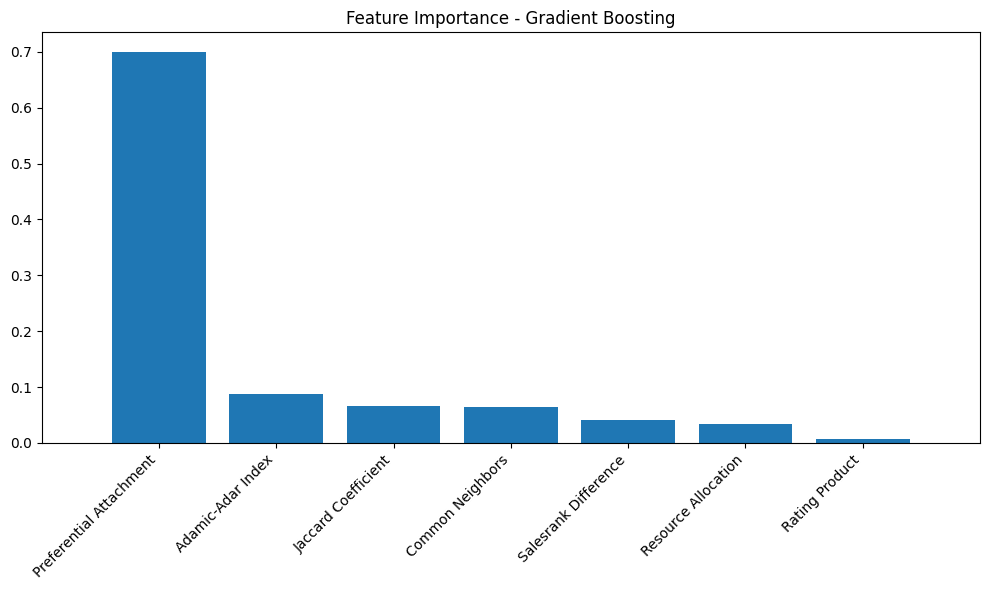


Feature Importance:
Preferential Attachment: 0.7001
Adamic-Adar Index: 0.0876
Jaccard Coefficient: 0.0665
Common Neighbors: 0.0644
Salesrank Difference: 0.0410
Resource Allocation: 0.0338
Rating Product: 0.0066

--------------------------------------------------
Training K-Nearest Neighbors...
Training time: 0.01 seconds
Accuracy: 0.4993
Precision: 0.5121
Recall: 0.4834
F1 Score: 0.4973
ROC-AUC: 0.5087


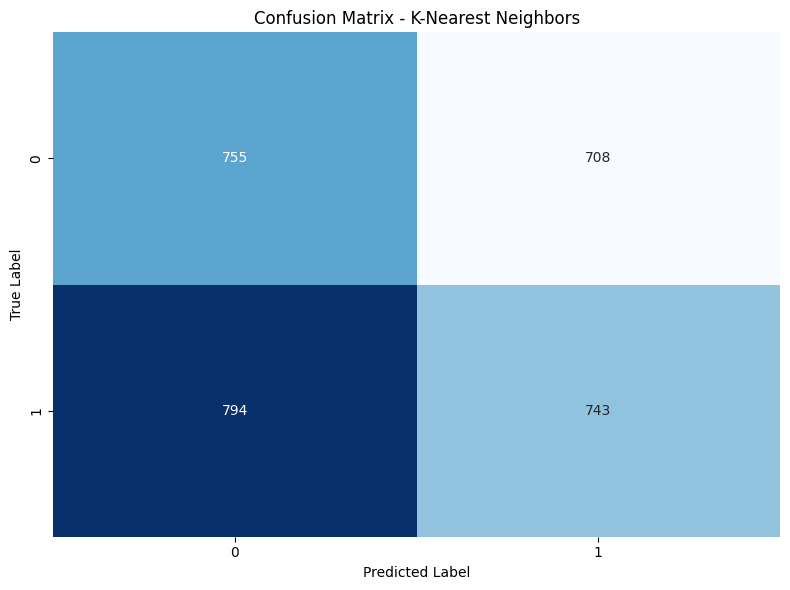


--------------------------------------------------
Training Neural Network...
Training time: 0.28 seconds
Accuracy: 0.5410
Precision: 0.8150
Recall: 0.1347
F1 Score: 0.2312
ROC-AUC: 0.5657


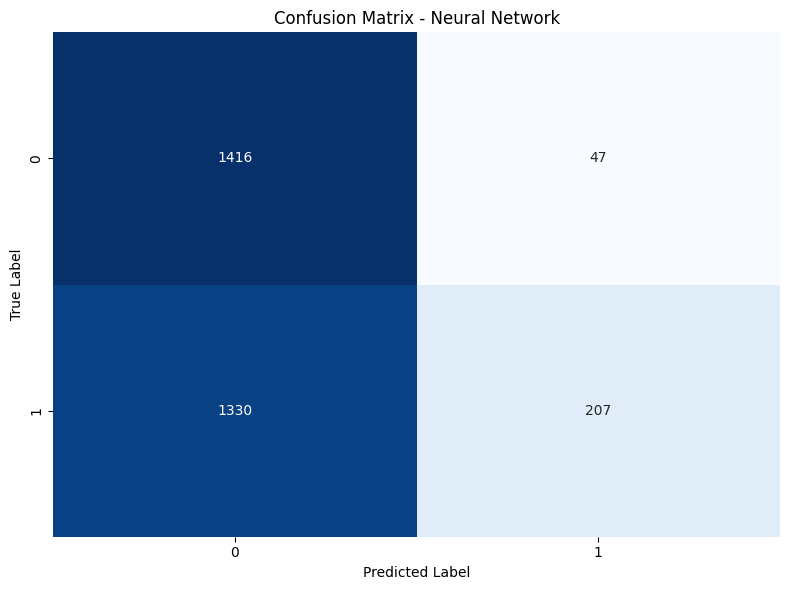


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score       AUC  Training Time (s)
0    Gradient Boosting  0.682667   0.665161  0.766428  0.712213  0.793517           0.720222
1  Logistic Regression  0.669333   0.795874  0.476903  0.596420  0.791993           1.902821
2        Random Forest  0.676333   0.680946  0.692908  0.686875  0.780488           0.739902
3       Neural Network  0.541000   0.814961  0.134678  0.231156  0.565709           0.282007
4  K-Nearest Neighbors  0.499333   0.512061  0.483409  0.497323  0.508724           0.010830


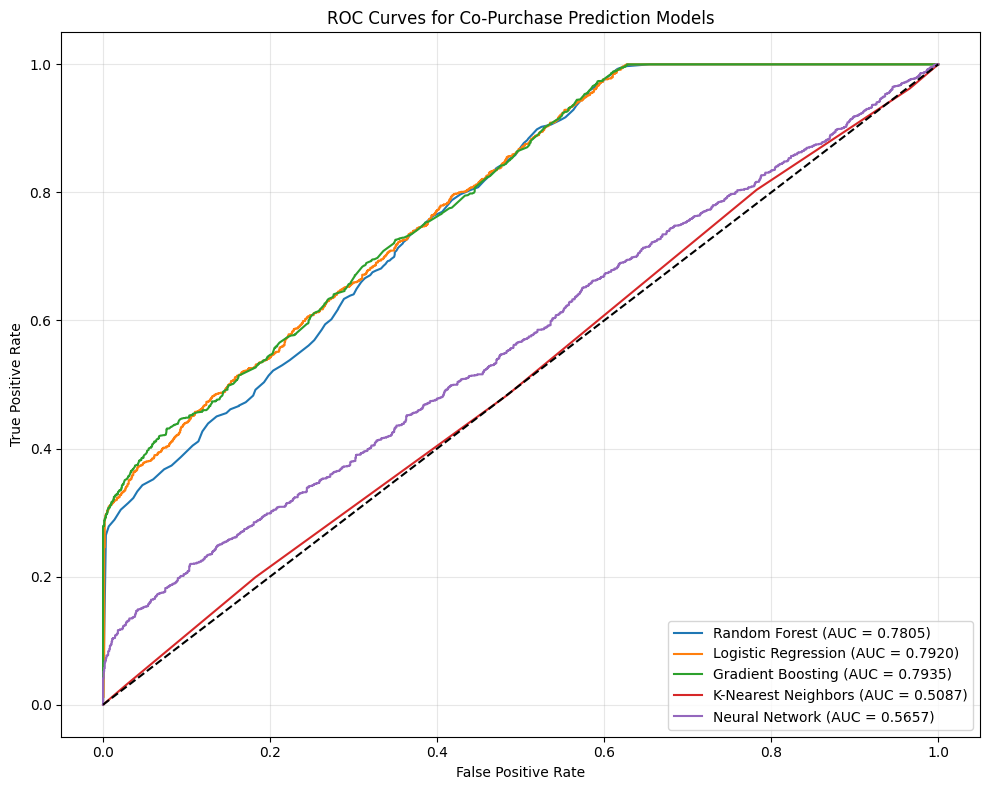


Best model: Gradient Boosting (AUC: 0.7935)

--------------------------------------------------
Tuning hyperparameters for Gradient Boosting...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'learning_rate': np.float64(0.03221339552022711), 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 250, 'subsample': np.float64(0.8493192507310232)}
Best CV score: 0.8062

--------------------------------------------------
Evaluating tuned Gradient Boosting...
Training time: 4.72 seconds
Accuracy: 0.6817
Precision: 0.6779
Recall: 0.7215
F1 Score: 0.6990
ROC-AUC: 0.7930


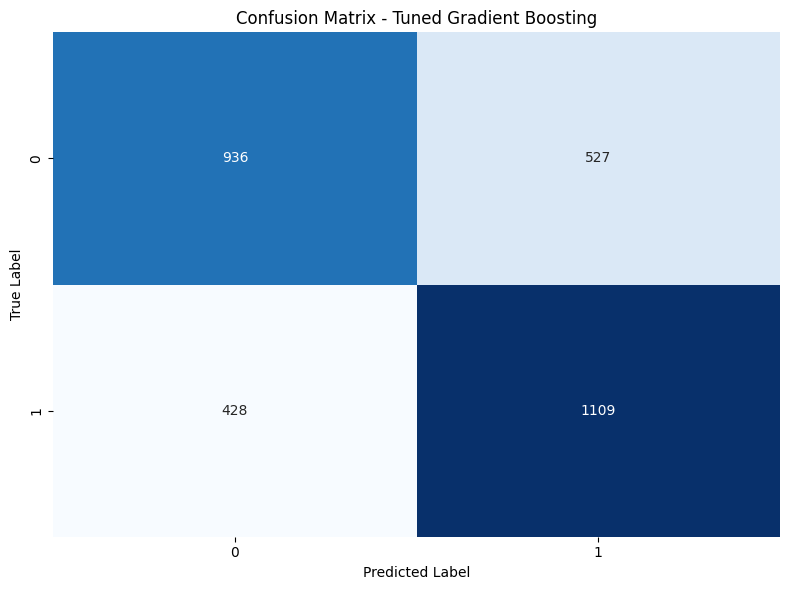

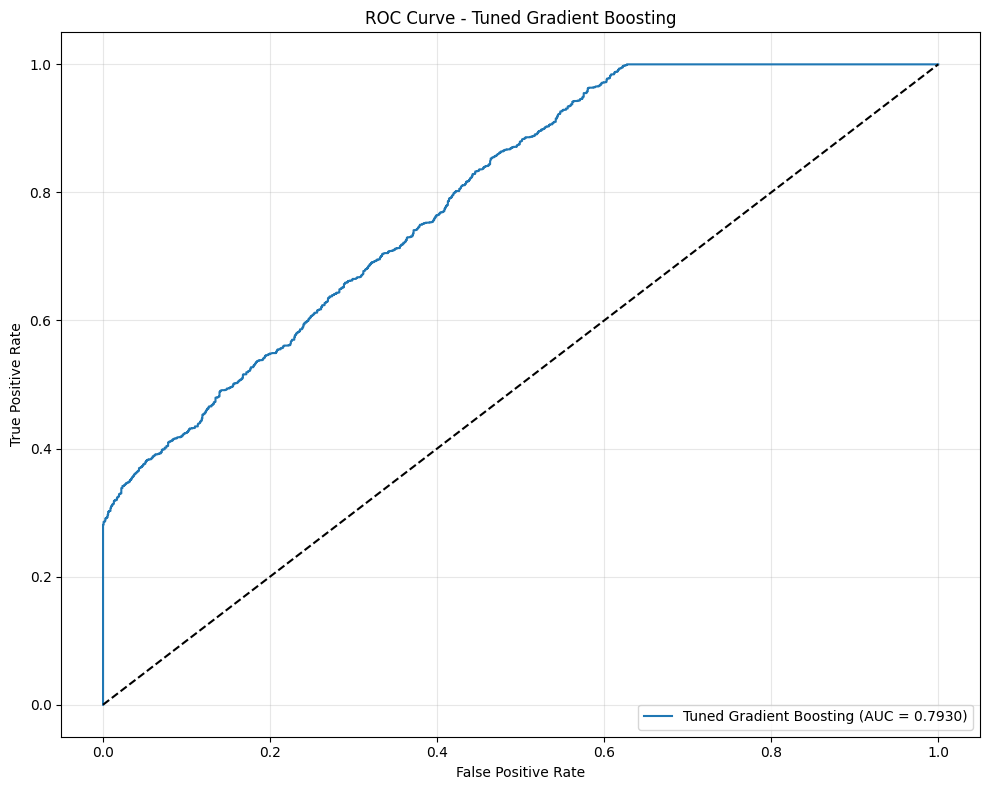


--------------------------------------------------
Predicting future co-purchases...
Pre-computing network properties...


Computing neighbors: 100%|██████████| 20684/20684 [00:00<00:00, 486087.68it/s]


Generating potential co-purchase pairs...


Processing nodes: 100%|██████████| 1000/1000 [00:00<00:00, 32317.57it/s]


Making predictions on 1451 potential co-purchases...

Top 20 most likely future co-purchases:
      source  target  probability
514    42846    4014     0.996436
68    115007   86907     0.996051
181   169377  135721     0.995884
1406   70893   43547     0.995830
926    34055   18946     0.995803
1194   58906   13217     0.995789
1439   96558   96559     0.995781
413   126395  174784     0.995709
506    89811   69444     0.995700
1279  231120  117104     0.995655
29    201089   80748     0.995645
80    112533  145911     0.995614
745   180256  136504     0.995586
1282   29441   40866     0.995561
685   127894   64195     0.995529
449    35342     448     0.995516
1220   82481  133568     0.995454
1402   18946     244     0.995419
716     3861      33     0.995357
638    96559   96558     0.995354

Top predicted co-purchases with titles:
    source                                       source_title  target  \
0    42846  Wisdom Sits in Places: Landscape and Language ...    4014   
1   1

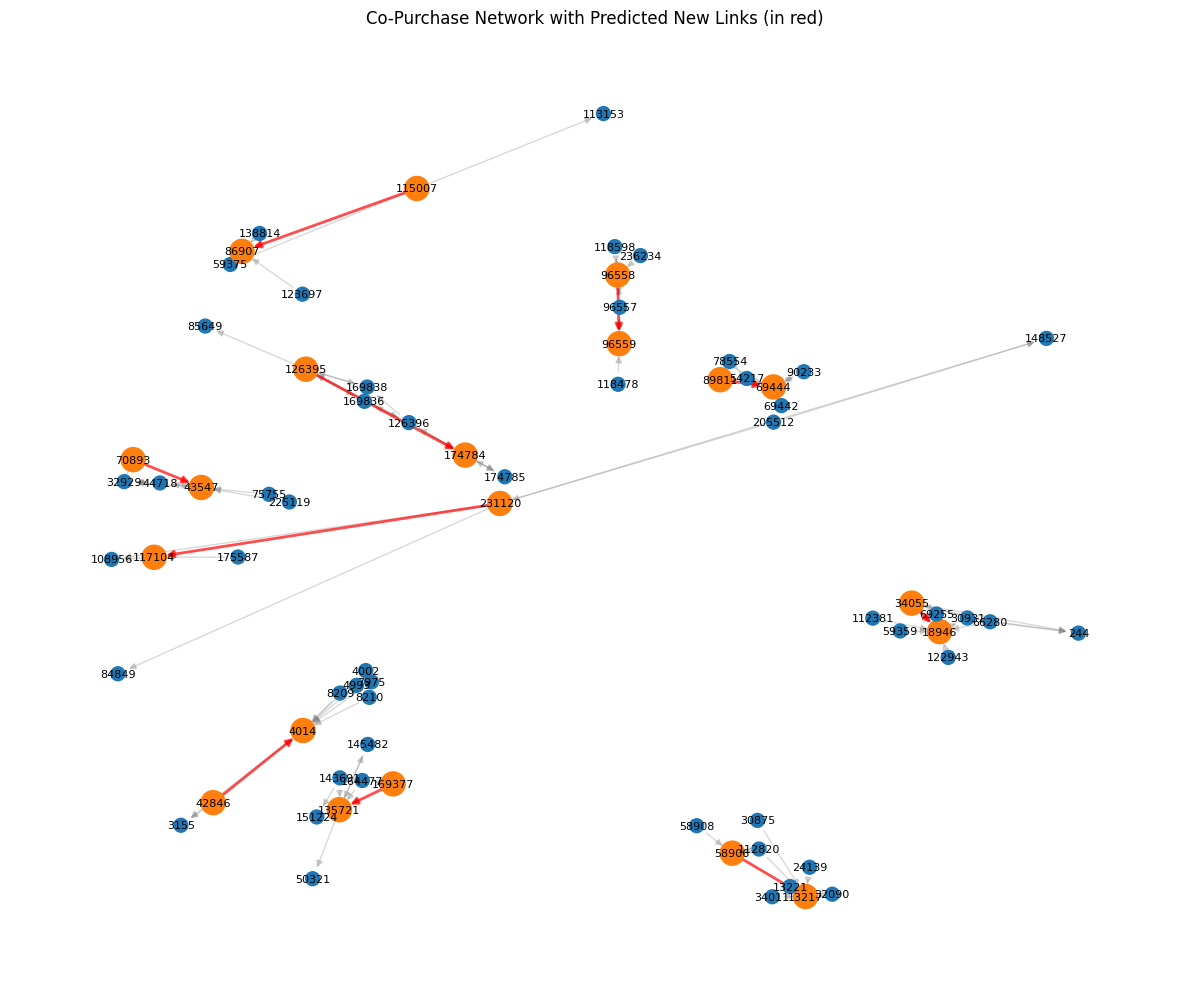

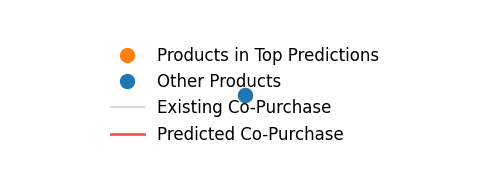

Model saved to 'copurchase_prediction_model.joblib'


In [8]:
final_model, top_predictions = main_analysis(X_train, X_test, y_train, y_test, G, df_filter)

In [9]:
from joblib import load
model = load('copurchase_prediction_model.joblib')

## Identifying the most likely future co-purchase links and visualize them.

In [10]:
def predict_pair_copurchase(G, model, df_filter, feature_names, book1, book2):
    """
    Predict co-purchase likelihood for a given pair of books.

    Parameters:
    - G: networkx.DiGraph, co-purchase network
    - model: trained sklearn model
    - df_filter: filtered dataframe with product metadata
    - feature_names: list of feature names
    - book1, book2: product IDs (string or int)

    Returns:
    - predicted probability of co-purchase
    """
    # Convert to undirected graph for similarity-based metrics
    G_undir = G.to_undirected()
    neighbors_dict = {node: set(G_undir.neighbors(node)) for node in G_undir.nodes()}
    degree_dict = dict(G.degree())
    in_degree_dict = dict(G.in_degree())
    out_degree_dict = dict(G.out_degree())

    # Ensure books exist
    if book1 not in G.nodes() or book2 not in G.nodes():
        print("One or both books not in graph.")
        return None

    # Compute features
    u_neighbors = neighbors_dict.get(book1, set())
    v_neighbors = neighbors_dict.get(book2, set())
    common_neighbors = u_neighbors.intersection(v_neighbors)
    union_size = len(u_neighbors.union(v_neighbors))

    features = {
        'common_neighbors': len(common_neighbors),
        'pref_attachment': out_degree_dict.get(book1, 0) * in_degree_dict.get(book2, 0),
        'jaccard': len(common_neighbors) / union_size if union_size > 0 else 0,
        'adamic_adar': sum(1 / np.log(degree_dict.get(w, 1)) for w in common_neighbors if degree_dict.get(w, 1) > 1),
        'resource_allocation': sum(1 / degree_dict.get(w, 1) for w in common_neighbors if degree_dict.get(w, 1) > 0)
    }

    # Salesrank and rating from node attributes
    node_attrs = G.nodes
    features['salesrank_diff'] = abs(
        node_attrs[book1].get('salesrank', 0) - node_attrs[book2].get('salesrank', 0)
    )
    features['rating_product'] = (
        node_attrs[book1].get('rating', 0) * node_attrs[book2].get('rating', 0)
    )

    # Convert to feature vector
    feature_vector = np.array([[features[key] for key in [
        'common_neighbors', 'pref_attachment', 'jaccard', 'adamic_adar',
        'resource_allocation', 'salesrank_diff', 'rating_product'
    ]]])

    # Predict probability
    prob = model.predict_proba(feature_vector)[0][1]

    print(f"\nPredicted co-purchase probability for {book1} and {book2}: {prob:.4f}")
    return prob


In [11]:
df_filter.head()

,id,title,group,salesrank,review_cnt,downloads,rating
11,12,Fantastic Food with Splenda : 160 Great Recipe...,Book,24741.0,12,12,4.5
32,33,"Double Jeopardy (T*Witches, 6)",Book,97166.0,4,4,5.0
38,39,Night of Many Dreams : A Novel,Book,57186.0,22,22,3.5
44,45,Beginning ASP.NET Databases using C#,Book,48408.0,4,4,4.0
73,74,Service Delivery (It Infrastructure Library Se...,Book,27507.0,2,2,4.0


In [12]:
print("Some sample book IDs:")
print(df_filter['id'].head(100).values)

Some sample book IDs:
[ 12  33  39  45  74  77  78  79  82 105 110 117 120 121 127 130 131 136
 137 147 148 170 173 185 187 193 196 199 203 215 224 244 249 255 256 257
 261 265 268 269 274 275 278 282 296 302 307 321 322 326 333 335 338 343
 344 347 393 396 399 413 422 426 435 439 448 450 472 494 495 498 510 527
 543 556 566 569 577 578 582 583 596 603 611 626 633 640 649 650 652 654
 666 673 681 695 696 698 700 702 710 724]


In [13]:
sample_id1 = df_filter['id'].iloc[0]
sample_id2 = df_filter['id'].iloc[1]

print(sample_id1 in G.nodes())
print(sample_id2 in G.nodes())


True
True


In [14]:
feature_names = [
    'Common Neighbors',
    'Preferential Attachment',
    'Jaccard Coefficient',
    'Adamic-Adar Index',
    'Resource Allocation',
    'Salesrank Difference',
    'Rating Product'
]

predict_pair_copurchase(G, model, df_filter, feature_names, 12, 695)



Predicted co-purchase probability for 12 and 695: 0.0047


np.float64(0.004693610587742266)

In [15]:
def get_id_from_title(df_filter, title_query):
    matches = df_filter[df_filter['title'].str.contains(title_query, case=False, na=False)]
    if matches.empty:
        print(f"No matches found for: {title_query}")
        return None
    print(matches[['id', 'title']])  # Show all matches
    return matches['id'].values[0]  # Return first match


In [16]:
book1_title = "Harry Potter"
book2_title = "Chamber of Secrets"

id1 = get_id_from_title(df_filter, book1_title)
id2 = get_id_from_title(df_filter, book2_title)

if id1 is not None and id2 is not None:
    predict_pair_copurchase(G, model, df_filter, feature_names, id1, id2)


            id                                              title
6061      6130  Harry Potter and the Order of the Phoenix (Boo...
8425      8504  Ultimate Unofficial Guide to the Mysteries of ...
34663    35063  Harry Potter and the Prisoner of Azkaban (Book 3)
71446    72215                   Harry Potter y la cámara secreta
76325    77140  Harry Potter And The Chamber Of Secrets: Colle...
83952    84842  Harry Potter and the Goblet of Fire (Book 4 Au...
92394    93385            Harry Potter y el prisionero de Azkaban
95161    96189       Harry Potter Paperback Boxed Set (Books 1-4)
95447    96481         Harry Potter und die Kammer des Schreckens
98414    99487     Harry Potter and the Sorcerer's Stone (Book 1)
138859  140389  Harry Potter Schoolbooks Box Set: Two Classic ...
146566  148185     Harry Potter and the Sorcerer's Stone (Book 1)
166516  168327                    Harry Potter Et LA Coupe De Feu
187442  189465  Harry Potter and the Chamber of Secrets (Book ...
188414  19

In [17]:
def get_id_from_title(df_filter, title_query):
    matches = df_filter[df_filter['title'].str.contains(title_query, case=False, na=False)]
    if matches.empty:
        print(f"No matches found for: {title_query}")
        return None
    print("\nMatching Titles Found:")
    print(matches[['id', 'title']].head(5))  # show top matches
    return matches['id'].values[0]  # return the ID of the first match


In [18]:
def predict_by_titles(title1, title2, df_filter, G, model, feature_names):
    id1 = get_id_from_title(df_filter, title1)
    id2 = get_id_from_title(df_filter, title2)

    if id1 is None or id2 is None:
        print("Prediction aborted: One or both titles not found.")
        return

    if id1 not in G.nodes or id2 not in G.nodes:
        print("Prediction aborted: One or both books are not in the graph.")
        return

    prob = predict_pair_copurchase(G, model, df_filter, feature_names, id1, id2)
    print(f"\n🔮 Predicted co-purchase probability for:\n📘 {title1}\n📗 {title2}\n➡️ {prob:.4f}")


In [19]:
predict_by_titles(
    "Harry Potter and the Sorcerer's Stone",
    "Harry Potter and the Chamber of Secrets",
    df_filter, G, model, feature_names
)



Matching Titles Found:
            id                                              title
98414    99487     Harry Potter and the Sorcerer's Stone (Book 1)
146566  148185     Harry Potter and the Sorcerer's Stone (Book 1)
209092  211463  Harry Potter and the Sorcerer's Stone (Book 1 ...
246280  249058  Harry Potter and the Sorcerer's Stone (Harry P...

Matching Titles Found:
            id                                              title
76325    77140  Harry Potter And The Chamber Of Secrets: Colle...
187442  189465  Harry Potter and the Chamber of Secrets (Book ...
199549  201752  Harry Potter and the Chamber of Secrets: Delux...
213764  216201   Harry Potter and the Chamber of Secrets (Book 2)

Predicted co-purchase probability for 99487 and 77140: 0.5261

🔮 Predicted co-purchase probability for:
📘 Harry Potter and the Sorcerer's Stone
📗 Harry Potter and the Chamber of Secrets
➡️ 0.5261


In [20]:
df_filter

,id,title,group,salesrank,review_cnt,downloads,rating
11,12,Fantastic Food with Splenda : 160 Great Recipe...,Book,24741.0,12,12,4.5
32,33,"Double Jeopardy (T*Witches, 6)",Book,97166.0,4,4,5.0
38,39,Night of Many Dreams : A Novel,Book,57186.0,22,22,3.5
44,45,Beginning ASP.NET Databases using C#,Book,48408.0,4,4,4.0
73,74,Service Delivery (It Infrastructure Library Se...,Book,27507.0,2,2,4.0
...,...,...,...,...,...,...,...
259145,262087,Focus Groups as Qualitative Research (Qualitat...,Book,49891.0,3,3,4.5
259147,262089,"Practical Chinese Reader, III",Book,129829.0,1,1,4.0
259154,262096,Lord Jim (Everyman's Library (Cloth)),Book,96905.0,55,55,4.0
259158,262100,Pinocchio,Book,111769.0,1,1,5.0


In [21]:
df_filter.to_csv('filtered_products.csv', index=False)

In [28]:
import pickle
import networkx as nx

# Save the graph
with open("copurchase_graph.gpickle", "wb") as f:
    pickle.dump(G, f)
